# Mixture density network: regression with uncertainty

In [218]:
import numpy as np

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop, Adam

import edward as ed
from edward.models import Categorical, Normal, Beta, PointMass
from edward.models import Mixture, Categorical, Normal
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import History
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

## Generate data

In [244]:
n_data = 2000
n_periods = 10
a = -0.5; b = 0.5
x_data = np.linspace(a, b, n_data)
y_data = np.sin(2*np.pi*n_periods*x_data/(b-a))+np.random.normal(loc=0, scale=0.2, size=n_data)
         #(x_data-a)/(b-a)*np.random.normal(loc=0, scale=0.2, size=n_data)
x_data = np.reshape(x_data, (n_data, 1))

n_pred = 2000
X_pred = np.reshape(np.linspace(1.25*a, 1.25*b, n_pred), (n_pred, 1))
y_pred = np.sin(2*np.pi*n_periods*X_pred/(b-a))
print('One period is {0} data points.'.format(n_data/n_periods))

One period is 200.0 data points.


No handles with labels found to put in legend.


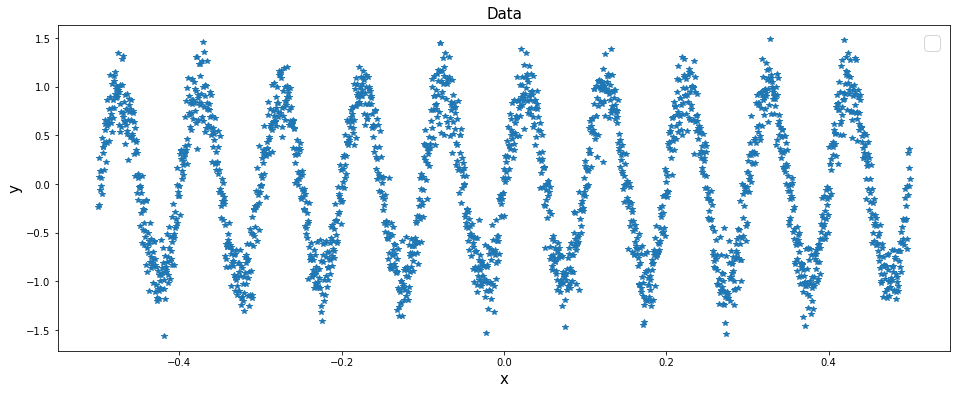

In [245]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data, '*')
plt.title('Data', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


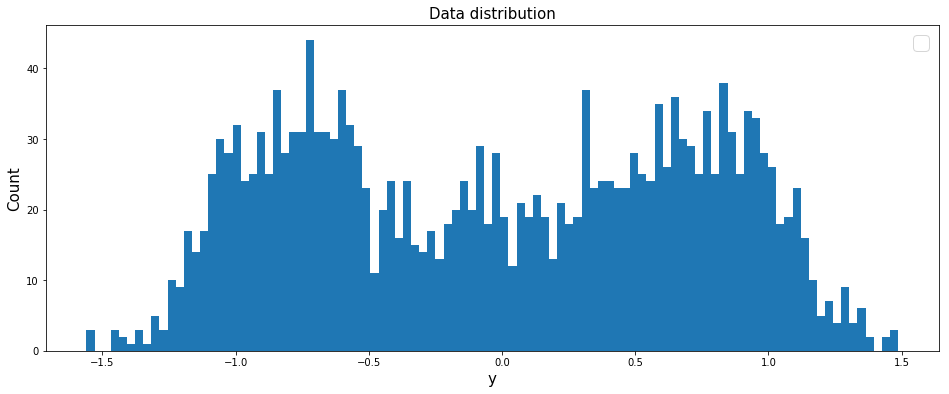

In [246]:
plt.figure(figsize=(16,6))
plt.hist(y_data, bins=100)
plt.title('Data distribution', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Hyperparameters

In [247]:
test_size = 0.25
batch_size = 64 
epochs = 20
D = 1     # Number of features
K = 1    # Number of mixture components

## Create supervised problem

In [248]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in test set: {0}.'.format(len(X_test)))

Data points in train set: 1500.
Data points in test set: 500.


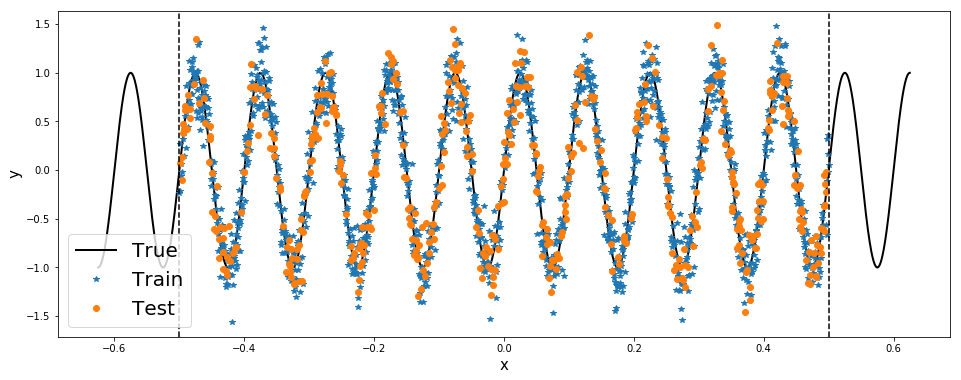

In [249]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_test, y_test, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [250]:
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))

Shape of features in training data: (1500, 1)
Shape of output in training data: (1500,)
Shape of features in test data: (500, 1)
Shape of output in test data: (500,)


## Feed forward neural network

### Build network

According to universal approximation theorem it should be possible to predict any function using a neural network of only one layer. Why doesnt this work? 
Why does the ANN learn from the middle and out? Is it more uncertain on the edges? 

In [189]:
def build_ffnn():
    X = Input(shape=(1,))
    h = Dense(units=128, activation='relu')(X)
    h = Dense(units=128, activation='relu')(h)
    h = Dense(units=128, activation='relu')(h)
    y = Dense(units=1, activation='linear')(h)
    model = Model(inputs=X, outputs=y)
    
    return model

In [161]:
model = build_ffnn()

### Optimizer

In [162]:
def compile_ffnn(lr):
    adam = Adam(lr=lr, 
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=None, 
                decay=0.0, 
                amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

### Train model

In [12]:
mse_ffnn = np.array([]).reshape(0,3)
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [13]:
lr = 1e-3
model = compile_ffnn(lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=1)
train_loss = np.append(train_loss, history.history['loss'])
test_loss = np.append(test_loss, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
1500/1500 [==============================] - 0s 203us/step - loss: 0.5498 - val_loss: 0.5550
Epoch 2/200
1500/1500 [==============================] - 0s 38us/step - loss: 0.5478 - val_loss: 0.5559
Epoch 3/200
1500/1500 [==============================] - 0s 46us/step - loss: 0.5489 - val_loss: 0.5546
Epoch 4/200
1500/1500 [==============================] - 0s 45us/step - loss: 0.5470 - val_loss: 0.5544
Epoch 5/200
1500/1500 [==============================] - 0s 49us/step - loss: 0.5475 - val_loss: 0.5542
Epoch 6/200
1500/1500 [==============================] - 0s 37us/step - loss: 0.5470 - val_loss: 0.5547
Epoch 7/200
1500/1500 [==============================] - 0s 40us/step - loss: 0.5459 - val_loss: 0.5520
Epoch 8/200
1500/1500 [==============================] - 0s 37us/step - loss: 0.5454 - val_loss: 0.5518
Epoch 9/200
1500/1500 [==============================] - 0s 40us/step - loss: 0.5441 - val_loss: 0.5504
Epoch 10/200
150

1500/1500 [==============================] - 0s 37us/step - loss: 0.2376 - val_loss: 0.2533
Epoch 156/200
1500/1500 [==============================] - 0s 37us/step - loss: 0.2377 - val_loss: 0.2640
Epoch 157/200
1500/1500 [==============================] - 0s 39us/step - loss: 0.2306 - val_loss: 0.2506
Epoch 158/200
1500/1500 [==============================] - 0s 38us/step - loss: 0.2243 - val_loss: 0.2500
Epoch 159/200
1500/1500 [==============================] - 0s 39us/step - loss: 0.2190 - val_loss: 0.2373
Epoch 160/200
1500/1500 [==============================] - 0s 37us/step - loss: 0.2227 - val_loss: 0.2406
Epoch 161/200
1500/1500 [==============================] - 0s 38us/step - loss: 0.2207 - val_loss: 0.2264
Epoch 162/200
1500/1500 [==============================] - 0s 46us/step - loss: 0.2163 - val_loss: 0.2356
Epoch 163/200
1500/1500 [==============================] - 0s 38us/step - loss: 0.2188 - val_loss: 0.2516
Epoch 164/200
1500/1500 [==============================] - 0

In [14]:
mse_ffnn = np.append(mse_ffnn, [[n_epoch, train_loss[-1], test_loss[-1]]])

### Plot diagnostics

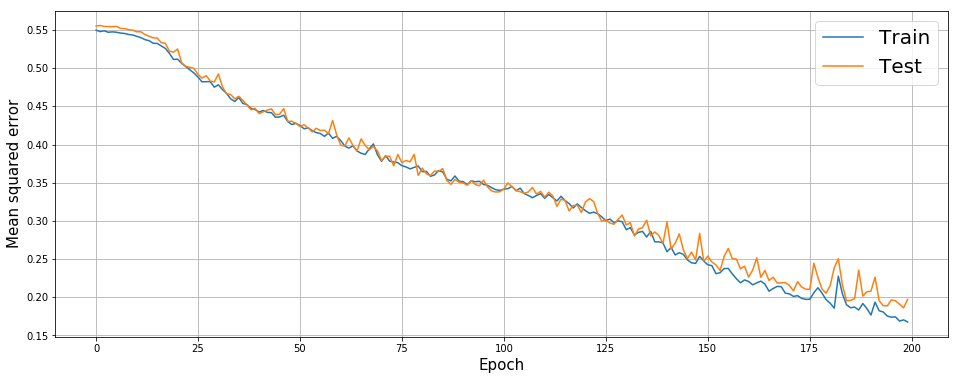

In [15]:
plt.figure(figsize=(16,6))
plt.plot(range(n_epoch), train_loss, label='Train')
plt.plot(range(n_epoch), test_loss, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Plot predictions

##### After 200 epochs

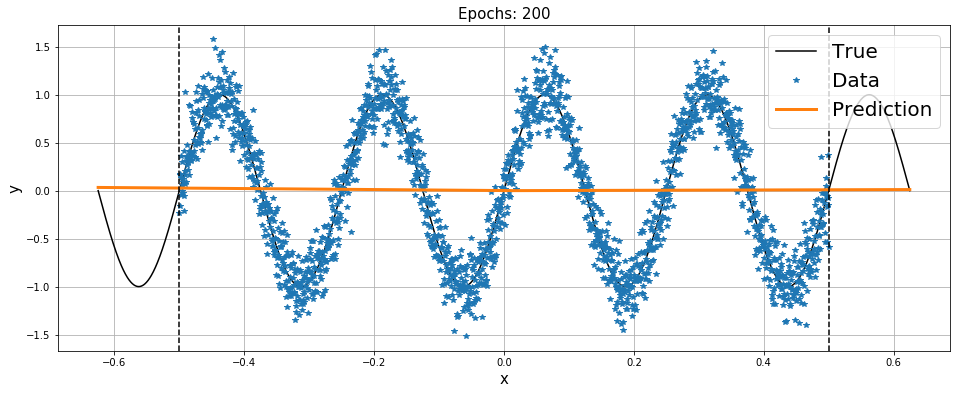

In [166]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 200', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 400 epochs

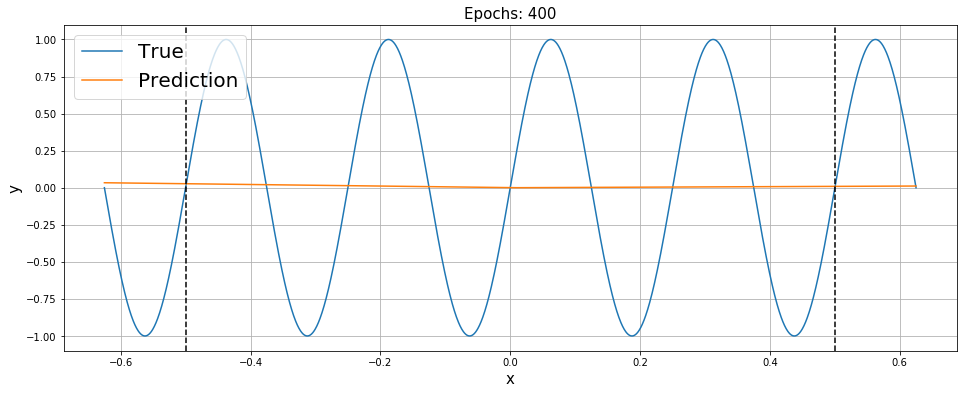

In [167]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, label='True')
plt.plot(X_pred, y_pred_model, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 400', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 600 epochs

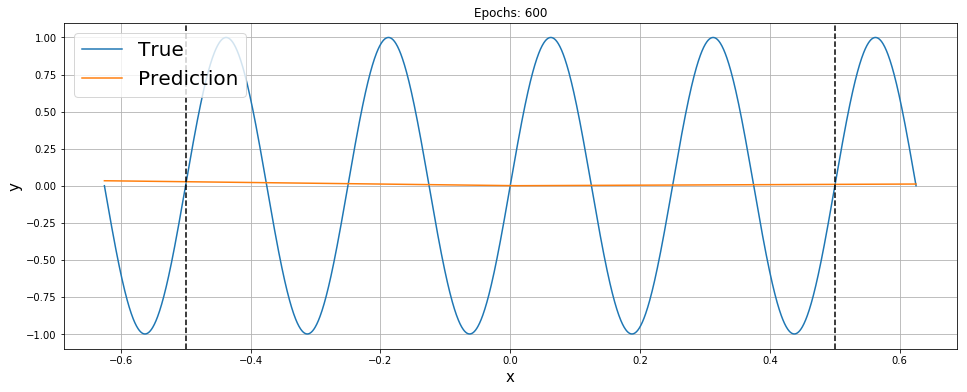

In [168]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, label='True')
plt.plot(X_pred, y_pred_model, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 600')
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 800 epochs

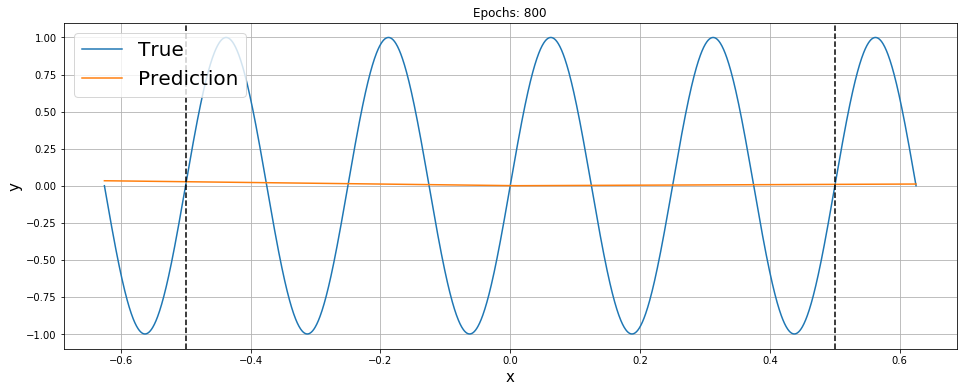

In [169]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, label='True')
plt.plot(X_pred, y_pred_model, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 800')
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Mixture density network

### Build network

In [251]:
def build_mdn(X):
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(X)
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(h)
    h = Dense(units=10, activation='relu', kernel_initializer='lecun_normal')(h)
    
    weights = Dense(units=K, activation='linear')(h)
    mus = Dense(units=K, activation='linear')(h)
    sigmas = Dense(units=K, activation=tf.exp)(h) # Could be softplus
    
    return weights, mus, sigmas

In [252]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

In [253]:
weights, mus, sigmas = build_mdn(X_ph)

cat = Categorical(logits=weights)
components = []
components.extend([Normal(loc=mu, scale=sigma) for mu, sigma 
                   in zip(tf.unstack(tf.transpose(mus)),tf.unstack(tf.transpose(sigmas)))])
y = ed.models.Mixture(cat=cat, components=components)

inference = ed.MAP(data={y: y_ph})

### Optimizer

In [254]:
lr_ph = tf.placeholder(tf.float32, shape=[], name='lr')
optim = 'Adam'
if optim == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_ph,
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1e-08)
elif optim == 'RMSprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr_ph,
                                          decay=0.9,
                                          epsilon=1e-10)
elif optim == 'Adagrad': 
    optimizer = tf.train.AdagradOptimizer(learning_rate=lr_ph,
                                          initial_accumulator_value=0.1,
                                          use_locking=False)
    
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [255]:
sess = ed.get_session()
tf.set_random_seed(1337)
tf.global_variables_initializer().run()

In [256]:
mse_mdn = np.array([]).reshape(0,3)
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [264]:
# lr = 5e-4 1e-4 5e-5 1e-5
#lrs = [1e-4, 5e-5, 1e-5, 5e-6]
#lrs = [1e-5, 1e-5, 1e-5, 1e-5]
lrs = [0.0001]
for lr in lrs: 
    n_epoch_add = 20000
    train_loss = np.concatenate((train_loss,np.zeros(n_epoch_add)))
    test_loss = np.concatenate((test_loss,np.zeros(n_epoch_add)))
    inference.n_print = 100
    inference.progbar.target = n_epoch+n_epoch_add
    for i in range(n_epoch,n_epoch+n_epoch_add):
        info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train, lr_ph: lr})
        train_loss[i] = info_dict['loss']
        test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
        inference.print_progress(info_dict)

    n_epoch = n_epoch+n_epoch_add

40000/40000 [100%] ██████████████████████████████ Elapsed: 336s | Loss: 990.970


In [265]:
#mse_mdn = np.append(mse_mdn, [[n_epoch, train_loss[-1], test_loss[-1]]])

### Plot diagnostics

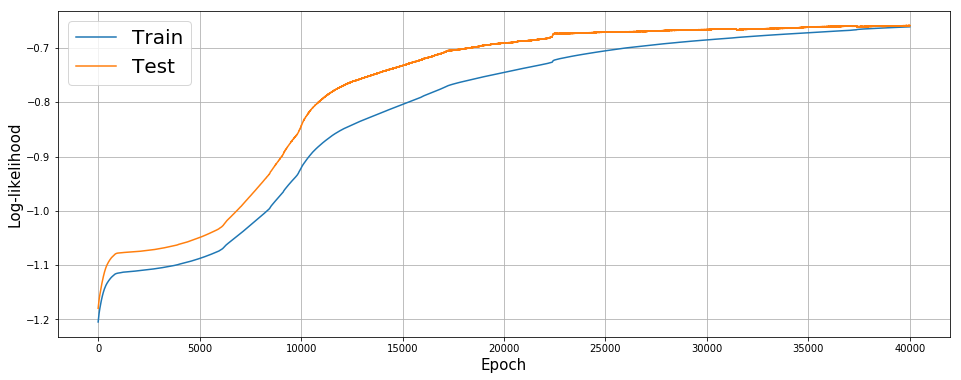

In [266]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [267]:
train_weights, train_mus, train_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_train})
test_weights, test_mus, test_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_test})
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})

### Plot predictions

In [268]:
class Mixture():
    
    def __init__(self, y, quantiles, pred_weights, pred_mus, pred_sigmas):
        # If x does not have high enough resolution. then this will not work. So make a check that enough points capture the pdf
        self.y = y
        self.quantiles = quantiles
        self.pred_weights = pred_weights
        self.pred_mus = pred_mus
        self.pred_sigmas = pred_sigmas
        
        self.mean()
        self.pdf()
        self.cdf()
        self.quantile()
    
    def mean(self):
        
        mean = self.pred_weights*self.pred_mus
        self.mean_mix = np.sum(mean, axis=1)
        
    def pdf(self):

        pdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                pdf[:,i,j] = self.pred_weights[i,j] * stats.norm.pdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.pdf_mix = np.sum(pdf, axis=2)
    
    def cdf(self):

        cdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                cdf[:,i,j] = self.pred_weights[i,j] * stats.norm.cdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.cdf_mix = np.sum(cdf, axis=2)
    
    def quantile(self):
        
        self.quantiles_mix = np.empty([self.pred_weights.shape[0], len(self.quantiles)])            
        for i in range(self.pred_weights.shape[0]):
            for k, q in enumerate(self.quantiles):
                
                f = interp1d(self.y, self.cdf_mix[:,i], kind='linear')
                self.quantiles_mix[i,k] = optimize.brentq(lambda y: f(y)-q, self.y[0], self.y[-1])


In [269]:
def plot_uncertainty(mixture, X_pred, y_pred):
    n_quantiles = len(mixture.quantiles)
    alpha = np.linspace(0.1,0.4,int(n_quantiles/2))
    fig, ax = plt.subplots(figsize=(16,6))
    for i in range(int(n_quantiles/2)):
        ax.fill_between(X_pred[:,0], mixture.quantiles_mix[:,i], mixture.quantiles_mix[:,-(1+i)], color='b', linewidth=0.0, alpha=alpha[i])

    ax.plot(X_pred, y_pred, '-k', label='True')
    plt.plot(x_data, y_data, '*', label='Data', alpha=0.3)
    ax.plot(X_pred, mixture.mean_mix, 'b', label='Prediction')
    ax.axvline(x=a, color='k', linestyle='--', alpha=0.5)
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
    plt.ylim([-2, 2])
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=20)

#### After 20000 epochs

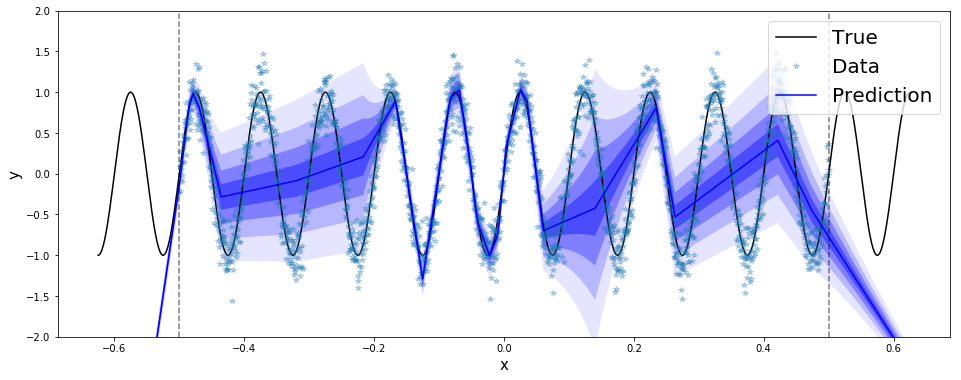

In [270]:
pred_weights_20000, pred_mus_20000, pred_sigmas_20000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture_20000 = Mixture(y, quantiles, pred_weights_20000, pred_mus_20000, pred_sigmas_20000)
plot_uncertainty(mixture_20000, X_pred, y_pred)

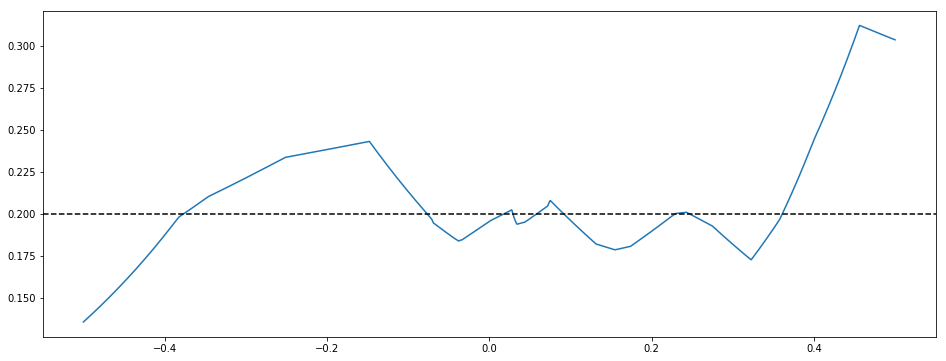

In [243]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(x_data, pred_sigmas_20000)
ax.axhline(0.2, color='k', linestyle='--',)
#plt.plot(x_data, (x_data-a)/(b-a))

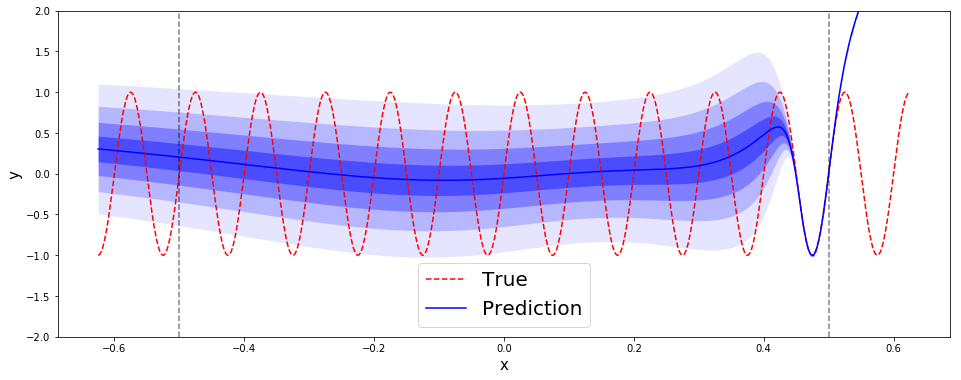

In [25]:
pred_weights_20000, pred_mus_20000, pred_sigmas_20000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture_20000 = Mixture(y, quantiles, pred_weights_20000, pred_mus_20000, pred_sigmas_20000)
plot_uncertainty(mixture_20000, X_pred, y_pred)

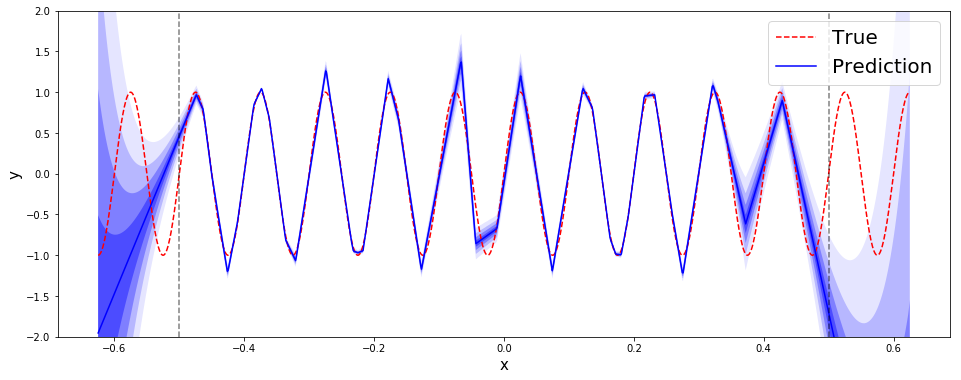

In [50]:
pred_weights_20000, pred_mus_20000, pred_sigmas_20000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture_20000 = Mixture(y, quantiles, pred_weights_20000, pred_mus_20000, pred_sigmas_20000)
plot_uncertainty(mixture_20000, X_pred, y_pred)

In [34]:
y = np.linspace(0.1,10,100)
x = y*(1-np.log(y))

In [35]:
np.trapz(y,x)

-90.1394423871864

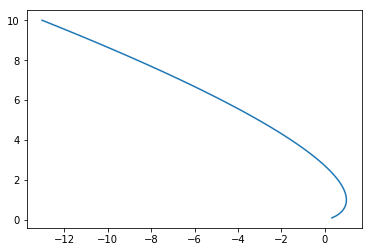

In [36]:
plt.plot(x,y)

In [37]:
plt.plot(pred_mus_10000)

NameError: name 'pred_mus_10000' is not defined

#### After 40000 epochs

In [ ]:
pred_weights_40000, pred_mus_40000, pred_sigmas_40000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-40, 40, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture_40000 = Mixture(y, quantiles, pred_weights_40000, pred_mus_40000, pred_sigmas_40000)
plot_uncertainty(mixture_40000, X_pred, y_pred)

#### After 60000 epochs 

In [ ]:
pred_weights_60000, pred_mus_60000, pred_sigmas_60000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-100, 100, 2000)
quantiles = np.arange(0.1,1,0.1)
mixture_60000 = Mixture(y, quantiles, pred_weights_60000, pred_mus_60000, pred_sigmas_60000)
plot_uncertainty(mixture_60000, X_pred, y_pred)
plt.title('Epochs: 60000') 

#### After epochs 80000

In [ ]:
pred_weights_80000, pred_mus_80000, pred_sigmas_80000 = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-1000, 1000, 2000)
quantiles = np.arange(0.1,1,0.1)
mixture_80000 = Mixture(y, quantiles, pred_weights_80000, pred_mus_80000, pred_sigmas_80000)
plot_uncertainty(mixture_80000, X_pred, y_pred)
plt.title('Epochs: 80000') 

In [ ]:
plt.plot(pred_mus_40000, label='1')
plt.plot(pred_mus_30000, label='2')
plt.legend()

In [ ]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-2, 2, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture_10000 = Mixture(y, quantiles, pred_weights, pred_mus, pred_sigmas)
plot_uncertainty(mixture_10000, X_pred, y_pred)

In [51]:
def sample_from_mixture(x, pred_weights, pred_mus, pred_sigmas, amount):

    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, mus, sigmas) in enumerate(zip(pred_weights, pred_mus, pred_sigmas)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(mus[index], sigmas[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
        
    return samples

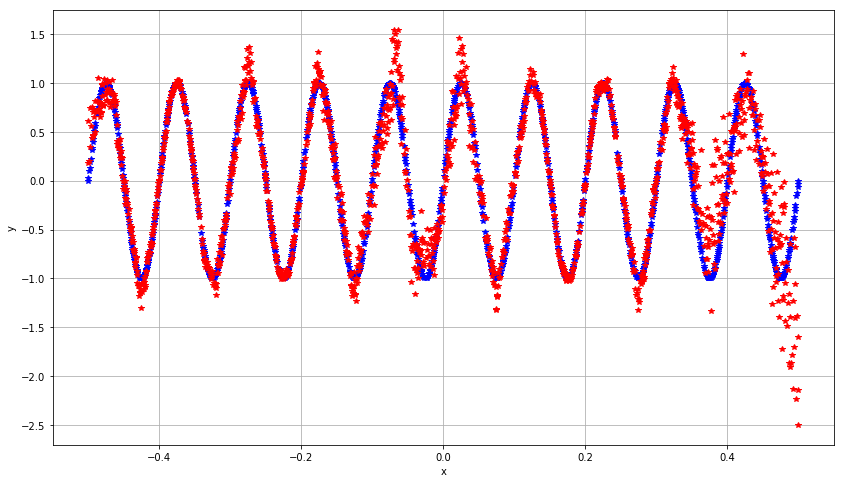

In [52]:
samples = sample_from_mixture(X_train, train_weights, train_mus, train_sigmas, amount=len(X_train))
plt.figure(figsize=(14,8))
plt.plot(X_train, y_train,'b*')
plt.plot(samples[:,0], samples[:,1],'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

### Plot samples

In [527]:
def plot_samples(weights, mus, sigmas, X_true, y_true, idx_samples, comp=True):
    
    for idx_sample in idx_samples: 
        fig, ax = plt.subplots(1,1,figsize=(20,6))
        y = np.linspace(-2, 2, 1000)
        final = np.zeros_like(y)
        
        for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(weights[idx_sample,:], mus[idx_sample,:], sigmas[idx_sample,:])):
            temp = weight_mix * stats.norm.pdf(y, mu_mix, sigma_mix)
            final = final + temp
            if comp:
                ax.plot(y, temp, label='Gaussian {0}'.format(str(i+1)))
        ax.plot(y, final, label='Mixture of Gaussians')
        ax.axvline(x=y_true[idx_sample], color='k')
        ax.legend(fontsize=13)
        fig.suptitle('Sample: {0}, x={1}'.format(str(idx_sample), str(X_true[idx_sample,0])))
    

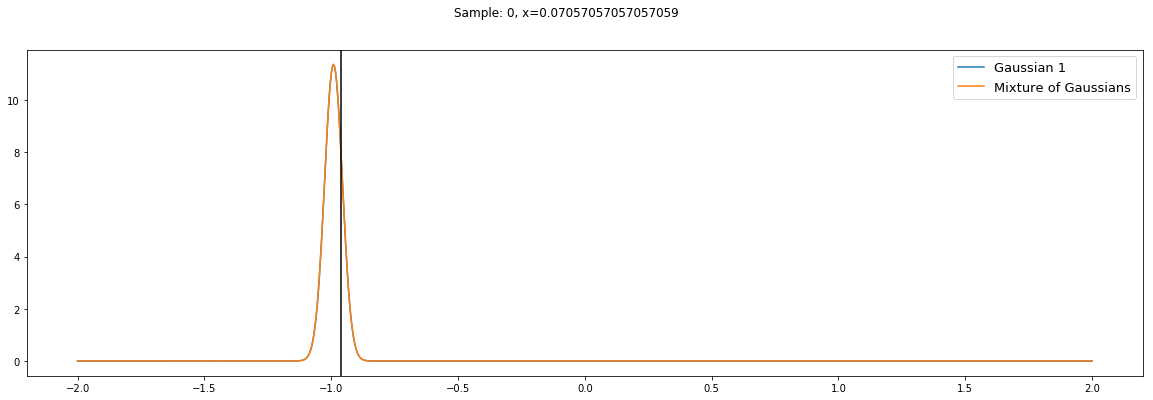

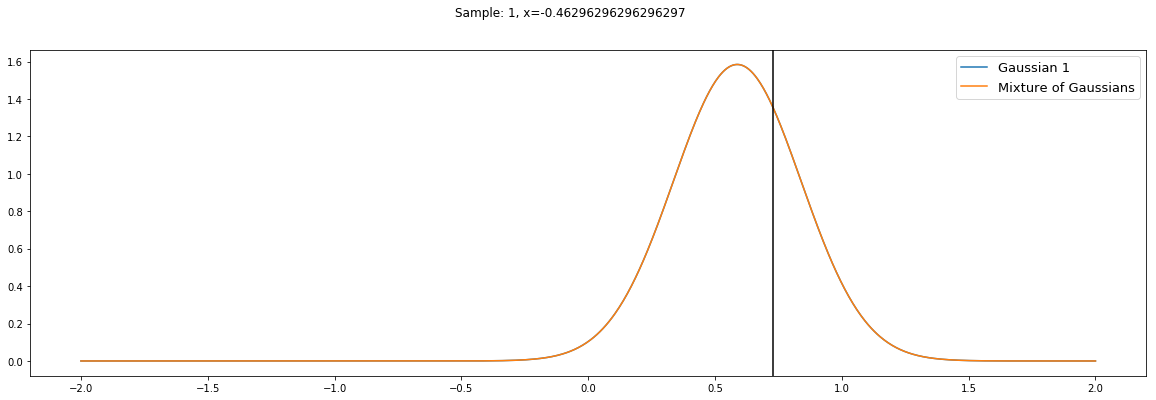

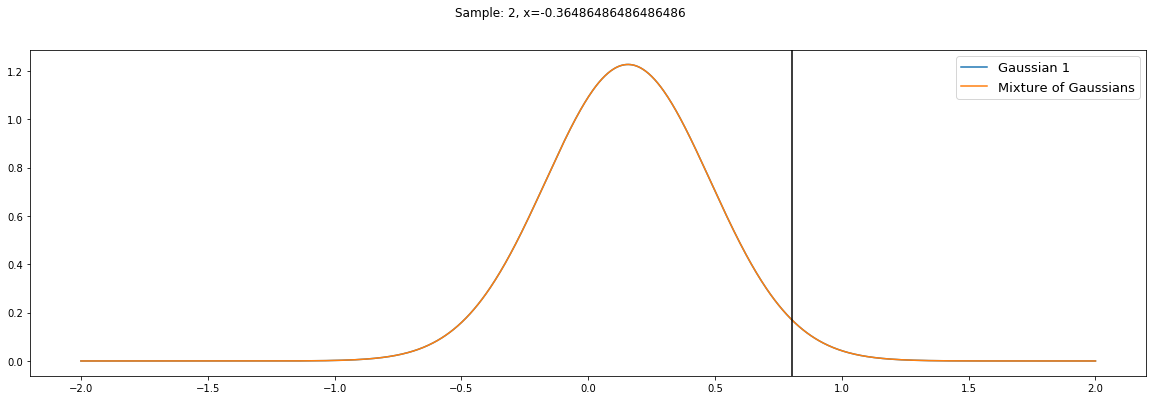

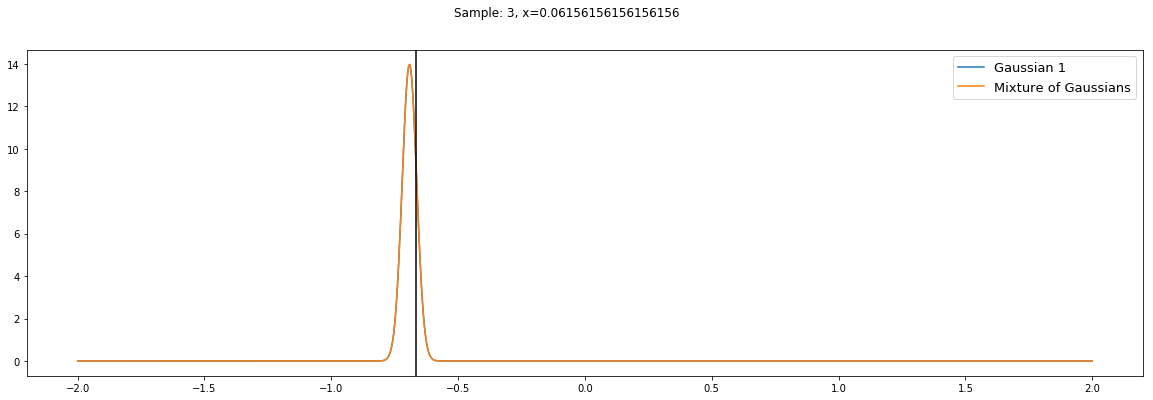

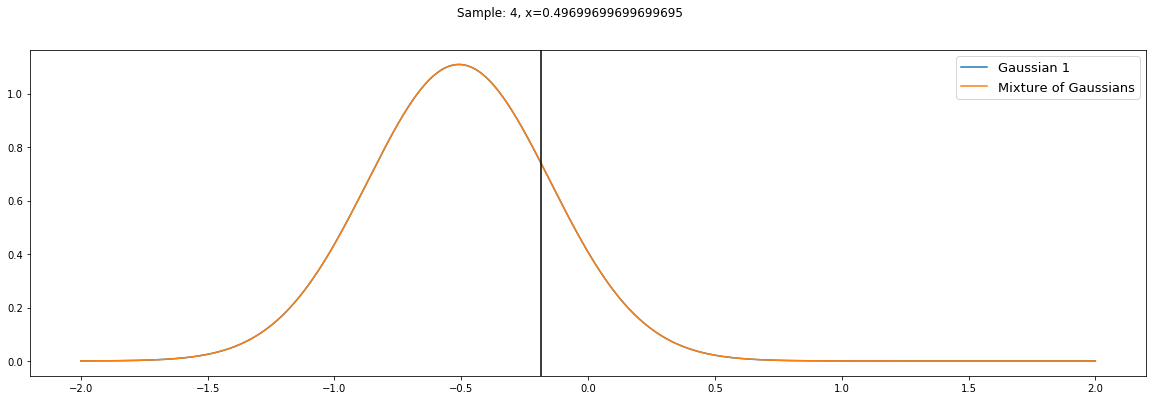

In [528]:
plot_samples(train_weights, train_mus, train_sigmas, X_train, y_train, idx_samples=range(5), comp=True)

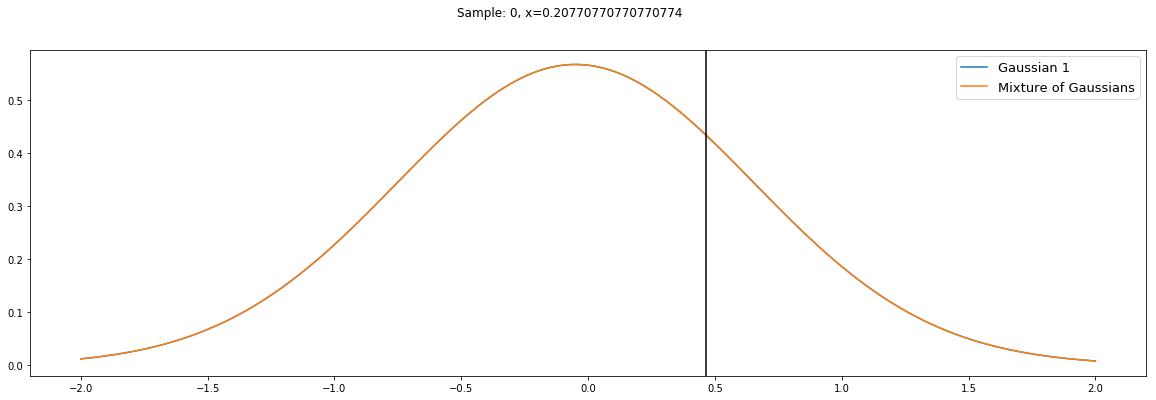

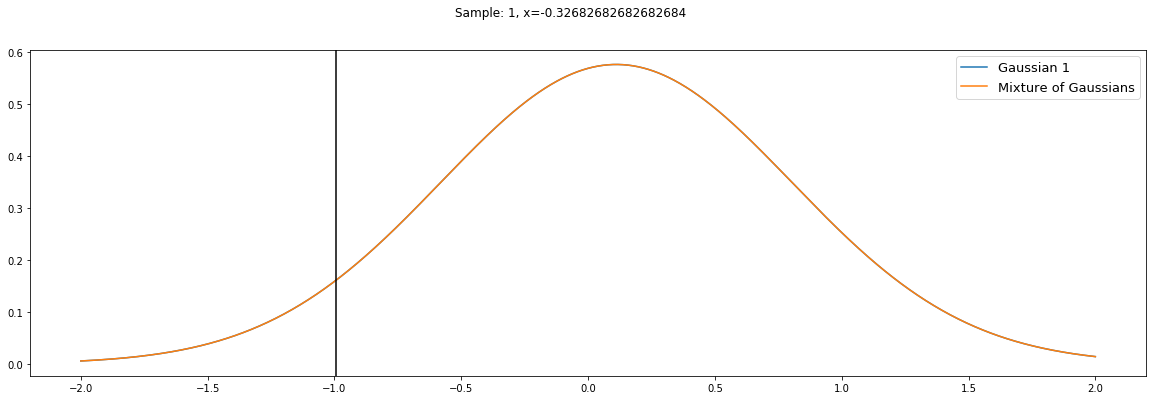

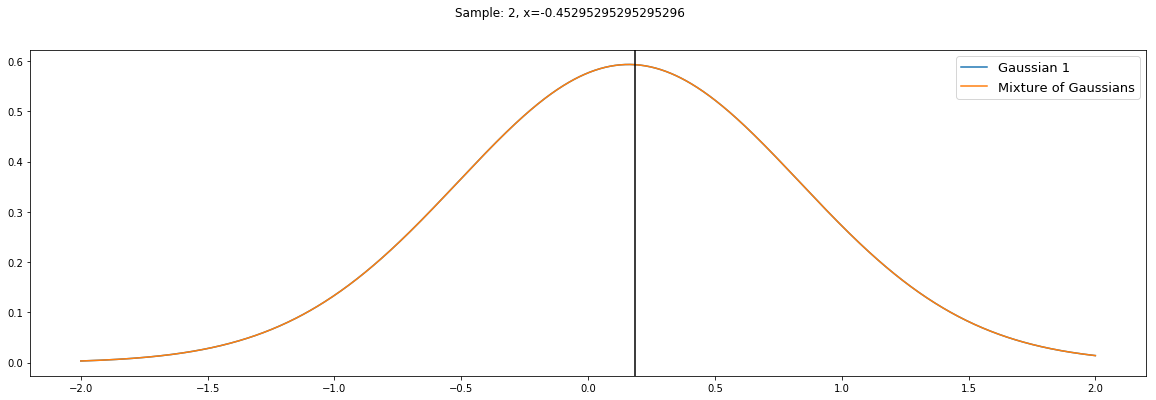

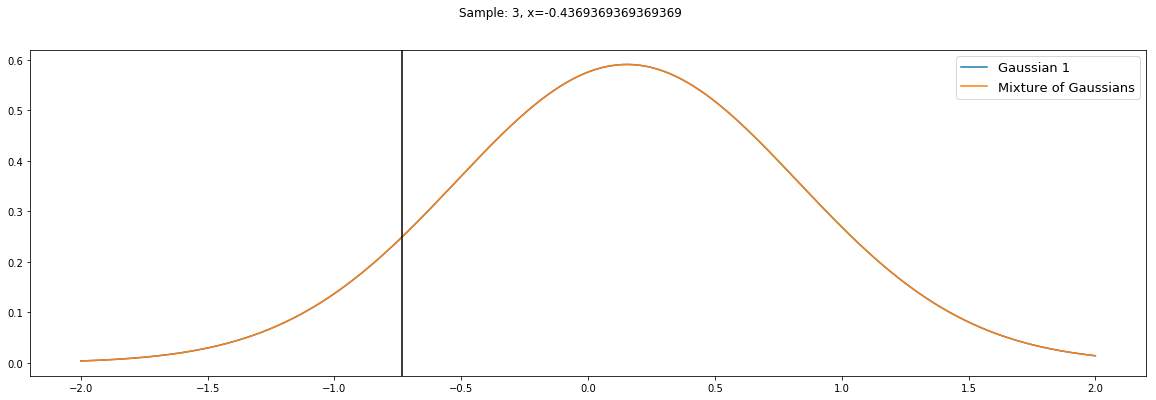

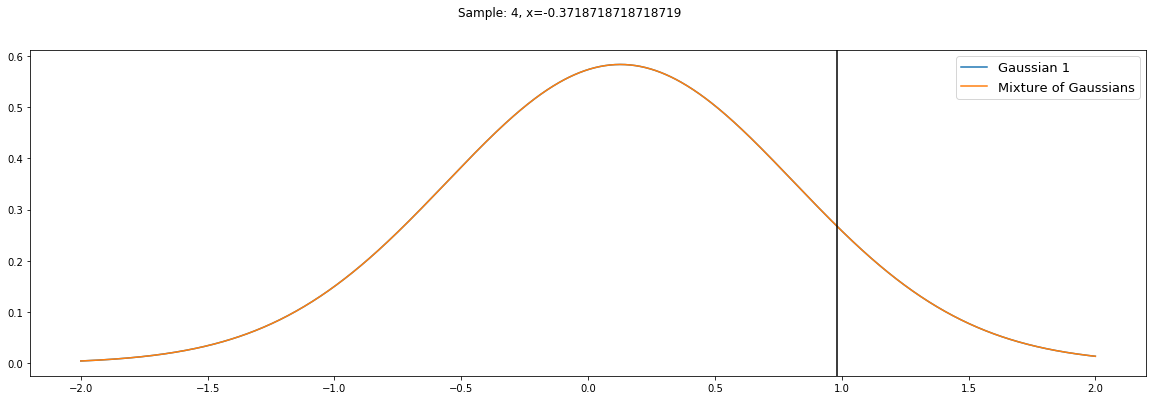

In [502]:
plot_samples(test_weights, test_mus, test_sigmas, X_test, y_test, idx_samples=range(5), comp=True)

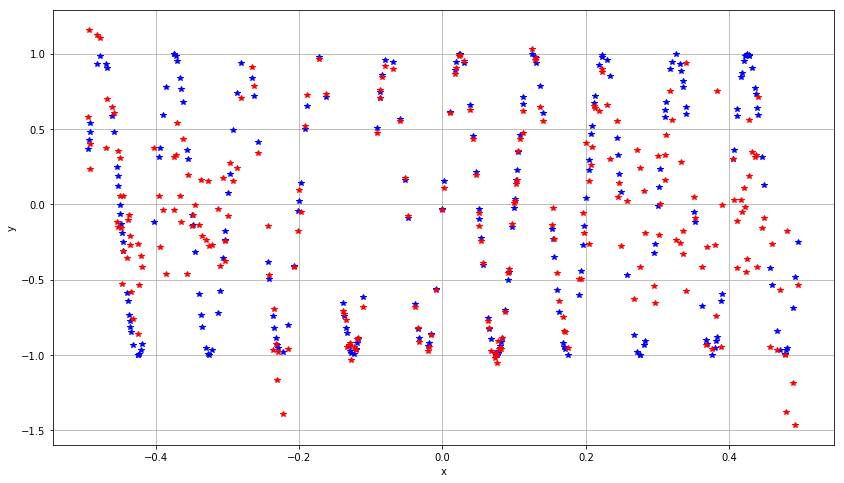

In [531]:
samples = sample_from_mixture(X_test, test_weights, test_mus, test_sigmas, amount=len(X_test))
plt.figure(figsize=(14,8))
plt.plot(X_test, y_test,'b*')
plt.plot(samples[:,0], samples[:,1],'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [546]:
class Mixture():
    
    def __init__(self, y, pred_weights, pred_mus, pred_sigmas):
        # If x does not have high enough resolution. then this will not work. So make a check that enough points capture the pdf
        self.y = y
        self.pred_weights = pred_weights
        self.pred_mus = pred_mus
        self.pred_sigmas = pred_sigmas
    
    def mean(self):
        
        mean = self.pred_weights*self.pred_mus
        self.mean_mix = np.sum(mean, axis=1)
        
    def pdf(self):

        pdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                pdf[:,i,j] = self.pred_weights[i,j] * stats.norm.pdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.pdf_mix = np.sum(pdf, axis=2)
    
    def cdf(self):

        cdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                cdf[:,i,j] = self.pred_weights[i,j] * stats.norm.cdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.cdf_mix = np.sum(cdf, axis=2)
    
    def quantile(self, quantiles):
        
        self.quantiles = quantiles
        self.quantiles_mix = np.empty([self.pred_weights.shape[0], len(self.quantiles)])
        for i in range(self.pred_weights.shape[0]):
            print(i)
            for k, q in enumerate(self.quantiles):
                
                f = interp1d(self.y, self.cdf_mix[:,i], kind='linear')
                plt.plot(self.y,f(self.y)-q)
                self.quantiles_mix[i,k] = optimize.brentq(lambda y: f(y)-q, self.y[0], self.y[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

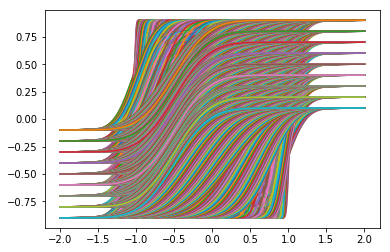

In [547]:
N = 2000
y = np.linspace(-2, 2, N)
quantiles = np.arange(0.1,1,0.1)
mixture = Mixture(y, pred_weights, pred_mus, pred_sigmas)
mixture.mean()
mixture.pdf()
mixture.cdf()
mixture.quantile(quantiles)
plt.plot(X_pred, pred_mus, X_pred, y_pred2)
plt.plot(X_pred, pred_sigmas)

In [223]:
y_train.shape

(750,)

In [ ]:
def plot_pred_ts(y_train, n=1):
    
    if isinstance(n, int):
        samples = np.random.randint(0, y_train.shape[0], n)
    elif isinstance(n, np.ndarray):
        samples = n
        
    n_quantiles = len(mixture.quantiles)
    alpha = np.linspace(0.1,0.4,int(n_quantiles/2))
    
    for sample in samples:
        fig, ax = plt.subplots()
        for i in range(int(n_quantiles/2)):
            ax.fill_between(range(sequence_size), mixture.quantiles_mix[sample,:,i], mixture.quantiles_mix[sample,:,-(1+i)], color='b', linewidth=0.0, alpha=alpha[i])

        ax.plot(range(sequence_size), mixture.mean_mix[sample,:], color='darkblue')
        ax.plot(range(sequence_size), Y_train[sample,:], color='r')
        plt.title('Sample: {0}'.format(sample))

    plt.show()

In [226]:
mixture.quantiles_mix.shape

(750, 9)

In [543]:
mixture.quantiles_mix[3,:]

array([-0.08312428,  0.03485931,  0.11993333,  0.192627  ,  0.26057178,
        0.32851663,  0.40120928,  0.48628536,  0.60426985])

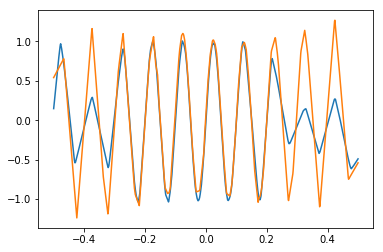

In [554]:
plt.plot(X_pred, pred_mus, X_pred, y_pred2)
plt.plot(X_pred, pred_sigmas)

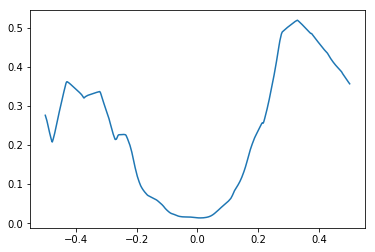

In [552]:
plt.plot(X_pred, pred_sigmas)

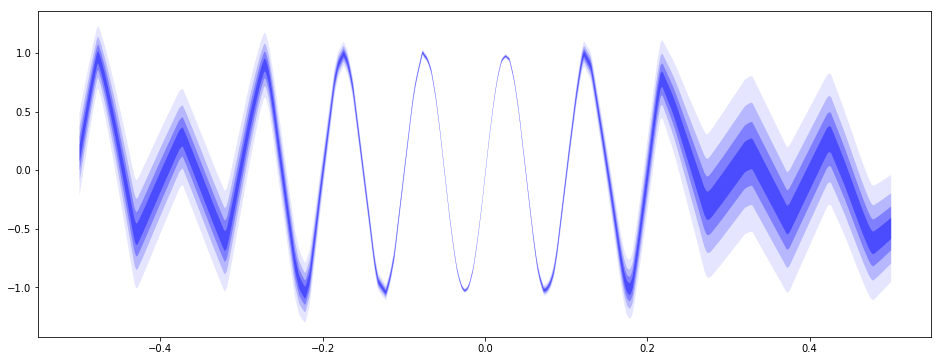

In [550]:
n_quantiles = len(mixture.quantiles)
alpha = np.linspace(0.1,0.4,int(n_quantiles/2))
fig, ax = plt.subplots(figsize=(16,6))
for i in range(int(n_quantiles/2)):
    ax.fill_between(X_pred[:,0], mixture.quantiles_mix[:,i], mixture.quantiles_mix[:,-(1+i)], color='b', linewidth=0.0, alpha=alpha[i])

In [549]:
X_pred.shape

(1000, 1)